# Library and Config

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import src.util as util
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [48]:
# import config files
config_data = util.load_config()

In [49]:
# function to clean column name
def clean_headers(val):
    if isinstance(val, str):
        # remove special chars (but skip emtpy spaces and all)
        val = "".join(char for char in val if char.isalnum() or char in (" ", "_"))
        # convert to snake case
        val = val.strip().lower().replace(" ", "_")
        return val
    else:
        return val

# Load Dataset

In [50]:
def load_dataset(config_data: dict) -> pd.DataFrame:
    # Load every set of data
    x_train = util.pickle_load(config_data["train_set_path"][0])
    y_train = util.pickle_load(config_data["train_set_path"][1])

    x_valid = util.pickle_load(config_data["valid_set_path"][0])
    y_valid = util.pickle_load(config_data["valid_set_path"][1])

    x_test = util.pickle_load(config_data["test_set_path"][0])
    y_test = util.pickle_load(config_data["test_set_path"][1])

    # Concatenate x and y each set
    train_set = pd.concat([x_train, y_train], axis=1)
    valid_set = pd.concat([x_valid, y_valid], axis=1)
    test_set = pd.concat([x_test, y_test], axis=1)

    # Return 3 set of data
    return train_set, valid_set, test_set


In [51]:
train_set, valid_set, test_set = load_dataset(config_data)

In [52]:
# check 1
train_set

,gender,age,married,number_of_dependents,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,...,contract,paperless_billing,payment_method,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,customer_status
824,Female,68,Y,0,5,68,None,Y,1.98,Y,...,One Year,Y,Credit Card,96.55,6581.90,0.0,0,134.64,6716.54,Churned
1985,Female,29,N,0,0,1,Offer E,Y,13.04,N,...,Month-to-Month,Y,Credit Card,69.95,69.95,0.0,0,13.04,82.99,Churned
3164,Male,64,N,0,0,25,Offer C,Y,8.31,Y,...,Month-to-Month,Y,Bank Withdrawal,84.80,2043.45,0.0,0,207.75,2251.20,Churned
2238,Male,70,N,0,0,47,None,Y,44.08,Y,...,One Year,Y,Credit Card,86.05,3865.60,0.0,0,2071.76,5937.36,Stayed
5405,Female,29,N,0,0,6,None,N,-999.00,Unknown,...,One Year,Y,Credit Card,49.25,255.60,0.0,0,0.00,255.60,Stayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4718,Female,22,N,0,0,15,Offer D,Y,45.84,Y,...,Month-to-Month,Y,Credit Card,25.40,399.60,0.0,0,687.60,1087.20,Churned
143,Male,64,Y,0,6,52,Offer B,Y,41.34,Y,...,One Year,Y,Credit Card,81.40,4354.45,0.0,0,2149.68,6504.13,Stayed
2703,Female,57,N,0,0,5,None,Y,6.17,N,...,Month-to-Month,N,Credit Card,19.85,108.05,0.0,0,30.85,138.90,Churned
4836,Male,43,Y,2,3,11,None,Y,16.67,N,...,Month-to-Month,Y,Bank Withdrawal,20.45,250.80,0.0,0,183.37,434.17,Stayed


# Handling Missing Values

In [53]:
def nan_detector(set_data: pd.DataFrame) -> pd.DataFrame:
    # Create copy of set data
    set_data = set_data.copy()

    # Replace -999 with NaN
    set_data.replace(-999, np.nan, inplace=True)

    # Return replaced set data
    return set_data


## Convert -999 to NaN

### Train Set

In [54]:
# describe
train_set.describe()

,age,number_of_dependents,number_of_referrals,tenure_in_months,avg_monthly_long_distance_charges,avg_monthly_gb_download,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
count,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000
mean,46.740676,0.470729,2.021249,34.438205,-75.953224,-184.349306,64.903664,2420.170455,2.058742,7.003469,798.211281,3223.326464
std,16.853122,0.967152,3.024010,23.875642,306.456995,414.796904,31.046237,2250.377715,8.128928,25.586963,856.205106,2840.220696
min,19.000000,0.000000,0.000000,1.000000,-999.000000,-999.000000,-10.000000,19.100000,0.000000,0.000000,0.000000,23.240000
25%,32.750000,0.000000,0.000000,12.000000,9.100000,4.000000,35.500000,535.187500,0.000000,0.000000,106.582500,835.595000
50%,46.000000,0.000000,0.000000,32.000000,22.890000,17.000000,70.950000,1566.825000,0.000000,0.000000,476.695000,2397.835000
75%,60.000000,0.000000,3.000000,56.250000,36.520000,27.000000,90.400000,3991.562500,0.000000,0.000000,1270.905000,5098.725000
max,80.000000,9.000000,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11868.340000


In [55]:
# check null
train_set.isnull().sum()

gender                               0
age                                  0
married                              0
number_of_dependents                 0
number_of_referrals                  0
tenure_in_months                     0
offer                                0
phone_service                        0
avg_monthly_long_distance_charges    0
multiple_lines                       0
internet_service                     0
internet_type                        0
avg_monthly_gb_download              0
online_security                      0
online_backup                        0
device_protection_plan               0
premium_tech_support                 0
streaming_tv                         0
streaming_movies                     0
streaming_music                      0
unlimited_data                       0
contract                             0
paperless_billing                    0
payment_method                       0
monthly_charge                       0
total_charges            

In [56]:
# replace -999 with nan. then check null values again
train_set = nan_detector(train_set)
train_set.isnull().sum()

gender                                 0
age                                    0
married                                0
number_of_dependents                   0
number_of_referrals                    0
tenure_in_months                       0
offer                                  0
phone_service                          0
avg_monthly_long_distance_charges    457
multiple_lines                         0
internet_service                       0
internet_type                          0
avg_monthly_gb_download              948
online_security                        0
online_backup                          0
device_protection_plan                 0
premium_tech_support                   0
streaming_tv                           0
streaming_movies                       0
streaming_music                        0
unlimited_data                         0
contract                               0
paperless_billing                      0
payment_method                         0
monthly_charge  

### Valid Set

In [57]:
# describe
valid_set.describe()

,age,number_of_dependents,number_of_referrals,tenure_in_months,avg_monthly_long_distance_charges,avg_monthly_gb_download,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
count,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000
mean,47.247976,0.479757,1.980769,34.314777,-73.466285,-183.074899,65.063866,2460.715283,1.943826,7.965587,783.725931,3250.462976
std,16.992407,0.968917,3.001964,24.035500,302.326751,412.895551,31.634355,2324.356229,7.630508,27.370601,835.472797,2905.762280
min,19.000000,0.000000,0.000000,1.000000,-999.000000,-999.000000,-10.000000,19.300000,0.000000,0.000000,0.000000,21.610000
25%,33.000000,0.000000,0.000000,12.000000,8.555000,4.000000,35.875000,546.750000,0.000000,0.000000,99.975000,844.140000
50%,47.000000,0.000000,0.000000,31.000000,22.530000,17.000000,71.975000,1539.025000,0.000000,0.000000,443.525000,2340.040000
75%,61.000000,0.000000,3.000000,58.000000,35.850000,27.000000,90.600000,3973.825000,0.000000,0.000000,1279.250000,5028.905000
max,80.000000,8.000000,10.000000,72.000000,49.980000,85.000000,118.600000,8670.100000,49.570000,150.000000,3564.000000,11979.340000


In [58]:
# check null
valid_set.isnull().sum()

gender                               0
age                                  0
married                              0
number_of_dependents                 0
number_of_referrals                  0
tenure_in_months                     0
offer                                0
phone_service                        0
avg_monthly_long_distance_charges    0
multiple_lines                       0
internet_service                     0
internet_type                        0
avg_monthly_gb_download              0
online_security                      0
online_backup                        0
device_protection_plan               0
premium_tech_support                 0
streaming_tv                         0
streaming_movies                     0
streaming_music                      0
unlimited_data                       0
contract                             0
paperless_billing                    0
payment_method                       0
monthly_charge                       0
total_charges            

In [59]:
# replace -999 with nan. then check null values again
valid_set = nan_detector(valid_set)
valid_set.isnull().sum()

gender                                 0
age                                    0
married                                0
number_of_dependents                   0
number_of_referrals                    0
tenure_in_months                       0
offer                                  0
phone_service                          0
avg_monthly_long_distance_charges     95
multiple_lines                         0
internet_service                       0
internet_type                          0
avg_monthly_gb_download              201
online_security                        0
online_backup                          0
device_protection_plan                 0
premium_tech_support                   0
streaming_tv                           0
streaming_movies                       0
streaming_music                        0
unlimited_data                         0
contract                               0
paperless_billing                      0
payment_method                         0
monthly_charge  

### Test Set

In [60]:
# describe
test_set.describe()

,age,number_of_dependents,number_of_referrals,tenure_in_months,avg_monthly_long_distance_charges,avg_monthly_gb_download,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue
count,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000
mean,46.366026,0.497472,2.059656,34.971689,-69.666188,-175.939333,65.589939,2458.759858,2.321416,7.148635,811.855662,3275.442740
std,16.638983,0.975014,3.048442,24.351035,298.066409,408.467864,30.841285,2278.054221,8.576785,25.198788,861.059497,2872.364946
min,19.000000,0.000000,0.000000,1.000000,-999.000000,-999.000000,-10.000000,18.850000,0.000000,0.000000,0.000000,22.540000
25%,33.000000,0.000000,0.000000,12.000000,9.910000,4.000000,40.250000,581.700000,0.000000,0.000000,115.140000,822.200000
50%,47.000000,0.000000,0.000000,34.000000,23.350000,17.000000,72.350000,1567.000000,0.000000,0.000000,472.680000,2386.040000
75%,59.000000,0.000000,3.000000,58.000000,36.340000,27.000000,90.250000,4097.050000,0.000000,0.000000,1303.550000,5238.330000
max,80.000000,7.000000,10.000000,72.000000,49.670000,85.000000,117.600000,8594.400000,49.510000,150.000000,3501.720000,11688.900000


In [61]:
# check null
test_set.isnull().sum()

gender                               0
age                                  0
married                              0
number_of_dependents                 0
number_of_referrals                  0
tenure_in_months                     0
offer                                0
phone_service                        0
avg_monthly_long_distance_charges    0
multiple_lines                       0
internet_service                     0
internet_type                        0
avg_monthly_gb_download              0
online_security                      0
online_backup                        0
device_protection_plan               0
premium_tech_support                 0
streaming_tv                         0
streaming_movies                     0
streaming_music                      0
unlimited_data                       0
contract                             0
paperless_billing                    0
payment_method                       0
monthly_charge                       0
total_charges            

In [62]:
# replace -999 with nan. then check null values again
test_set = nan_detector(test_set)
test_set.isnull().sum()

gender                                 0
age                                    0
married                                0
number_of_dependents                   0
number_of_referrals                    0
tenure_in_months                       0
offer                                  0
phone_service                          0
avg_monthly_long_distance_charges     92
multiple_lines                         0
internet_service                       0
internet_type                          0
avg_monthly_gb_download              195
online_security                        0
online_backup                          0
device_protection_plan                 0
premium_tech_support                   0
streaming_tv                           0
streaming_movies                       0
streaming_music                        0
unlimited_data                         0
contract                               0
paperless_billing                      0
payment_method                         0
monthly_charge  

## Handling `avg_monthly_long_distance_charges` and `avg_monthly_gb_download`       

### Handle Null Train Set

In [63]:
# calculate mean/meadian for imputation
impute_avg_monthly_long_distance_charges = int(train_set.avg_monthly_long_distance_charges.mean())
impute_avg_monthly_gb_download = int(train_set.avg_monthly_gb_download.median())

In [64]:
# create variable to save impute value
impute_values = {"avg_monthly_long_distance_charges": impute_avg_monthly_long_distance_charges,
                 "avg_monthly_gb_download": impute_avg_monthly_gb_download}
impute_values

{'avg_monthly_long_distance_charges': 25, 'avg_monthly_gb_download': 21}

In [65]:
# check null values before imputation
train_set.isnull().sum()

gender                                 0
age                                    0
married                                0
number_of_dependents                   0
number_of_referrals                    0
tenure_in_months                       0
offer                                  0
phone_service                          0
avg_monthly_long_distance_charges    457
multiple_lines                         0
internet_service                       0
internet_type                          0
avg_monthly_gb_download              948
online_security                        0
online_backup                          0
device_protection_plan                 0
premium_tech_support                   0
streaming_tv                           0
streaming_movies                       0
streaming_music                        0
unlimited_data                         0
contract                               0
paperless_billing                      0
payment_method                         0
monthly_charge  

In [66]:
# do imputation
train_set.fillna(value=impute_values, inplace=True)

In [67]:
# check null values before imputation
train_set.isnull().sum()

gender                               0
age                                  0
married                              0
number_of_dependents                 0
number_of_referrals                  0
tenure_in_months                     0
offer                                0
phone_service                        0
avg_monthly_long_distance_charges    0
multiple_lines                       0
internet_service                     0
internet_type                        0
avg_monthly_gb_download              0
online_security                      0
online_backup                        0
device_protection_plan               0
premium_tech_support                 0
streaming_tv                         0
streaming_movies                     0
streaming_music                      0
unlimited_data                       0
contract                             0
paperless_billing                    0
payment_method                       0
monthly_charge                       0
total_charges            

### Handle Null Valid Set

In [68]:
# check null values before imputation
valid_set.isnull().sum()

gender                                 0
age                                    0
married                                0
number_of_dependents                   0
number_of_referrals                    0
tenure_in_months                       0
offer                                  0
phone_service                          0
avg_monthly_long_distance_charges     95
multiple_lines                         0
internet_service                       0
internet_type                          0
avg_monthly_gb_download              201
online_security                        0
online_backup                          0
device_protection_plan                 0
premium_tech_support                   0
streaming_tv                           0
streaming_movies                       0
streaming_music                        0
unlimited_data                         0
contract                               0
paperless_billing                      0
payment_method                         0
monthly_charge  

In [69]:
# do imputation
valid_set.fillna(value=impute_values, inplace=True)

In [70]:
# check null values before imputation
valid_set.isnull().sum()

gender                               0
age                                  0
married                              0
number_of_dependents                 0
number_of_referrals                  0
tenure_in_months                     0
offer                                0
phone_service                        0
avg_monthly_long_distance_charges    0
multiple_lines                       0
internet_service                     0
internet_type                        0
avg_monthly_gb_download              0
online_security                      0
online_backup                        0
device_protection_plan               0
premium_tech_support                 0
streaming_tv                         0
streaming_movies                     0
streaming_music                      0
unlimited_data                       0
contract                             0
paperless_billing                    0
payment_method                       0
monthly_charge                       0
total_charges            

### Handle Null Test Set

In [71]:
# check null values before imputation
test_set.isnull().sum()

gender                                 0
age                                    0
married                                0
number_of_dependents                   0
number_of_referrals                    0
tenure_in_months                       0
offer                                  0
phone_service                          0
avg_monthly_long_distance_charges     92
multiple_lines                         0
internet_service                       0
internet_type                          0
avg_monthly_gb_download              195
online_security                        0
online_backup                          0
device_protection_plan                 0
premium_tech_support                   0
streaming_tv                           0
streaming_movies                       0
streaming_music                        0
unlimited_data                         0
contract                               0
paperless_billing                      0
payment_method                         0
monthly_charge  

In [72]:
# do imputation
test_set.fillna(value=impute_values, inplace=True)

In [73]:
# check null values before imputation
test_set.isnull().sum()

gender                               0
age                                  0
married                              0
number_of_dependents                 0
number_of_referrals                  0
tenure_in_months                     0
offer                                0
phone_service                        0
avg_monthly_long_distance_charges    0
multiple_lines                       0
internet_service                     0
internet_type                        0
avg_monthly_gb_download              0
online_security                      0
online_backup                        0
device_protection_plan               0
premium_tech_support                 0
streaming_tv                         0
streaming_movies                     0
streaming_music                      0
unlimited_data                       0
contract                             0
paperless_billing                    0
payment_method                       0
monthly_charge                       0
total_charges            

# Drop Features

In [74]:
train_set = train_set.drop(columns=["number_of_dependents", "total_refunds", "total_extra_data_charges"])
valid_set = valid_set.drop(columns=["number_of_dependents", "total_refunds", "total_extra_data_charges"])
test_set = test_set.drop(columns=["number_of_dependents", "total_refunds", "total_extra_data_charges"])

In [75]:
len(train_set)

4612

# Remove Outliers

In [76]:
# # create function to remove outliers
# # def remove_outliers(set_data):
# num_col = train_set.select_dtypes(
#     include=['int64', 'float64']).columns.to_list()
# set_data = train_set.copy()
# list_of_set_data = list()

# for col_name in num_col:
#     q1 = set_data[col_name].quantile(0.25)
#     q3 = set_data[col_name].quantile(0.75)
#     iqr = q3 - q1
#     set_data = set_data[~((set_data[col_name] < (q1 - 1.5 * iqr))
#                           | (set_data[col_name] > (q3 + 1.5 * iqr)))].copy()
# #     list_of_set_data.append(set_data_cleaned.copy())

# # set_data_cleaned = pd.concat(list_of_set_data)
# # count_duplicated_index = set_data_cleaned.index.value_counts()
# # used_index_data = count_duplicated_index[count_duplicated_index == (set_data.shape[1]-1)].index
# # set_data_cleaned = set_data_cleaned.loc[used_index_data].drop_duplicates()

# # return set_data_cleaned
# set_data


In [77]:
# # create function to remove outliers
# def remove_outliers(set_data):
#     set_data = set_data.copy()
#     list_of_set_data = list()

#     for col_name in set_data.columns[:-1]:
#         q1 = set_data[col_name].quantile(0.25)
#         q3 = set_data[col_name].quantile(0.75)
#         iqr = q3 - q1
#         set_data_cleaned = set_data[~((set_data[col_name] < (q1 - 1.5 * iqr)) | (set_data[col_name] > (q3 + 1.5 * iqr)))].copy()
#         list_of_set_data.append(set_data_cleaned.copy())

#     set_data_cleaned = pd.concat(list_of_set_data)
#     count_duplicated_index = set_data_cleaned.index.value_counts()
#     used_index_data = count_duplicated_index[count_duplicated_index == (set_data.shape[1]-1)].index
#     set_data_cleaned = set_data_cleaned.loc[used_index_data].drop_duplicates()

#     return set_data_cleaned

In [78]:
# create function to remove outliers
def remove_outliers(set_data):
    num_col = train_set.select_dtypes(include=['int64', 'float64']).columns.to_list()
    
    set_data = train_set.copy()
    list_of_set_data = list()

    for col_name in num_col:
        q1 = set_data[col_name].quantile(0.25)
        q3 = set_data[col_name].quantile(0.75)
        iqr = q3 - q1
        set_data = set_data[~((set_data[col_name] < (q1 - 1.5 * iqr))
                            | (set_data[col_name] > (q3 + 1.5 * iqr)))].copy()

    return set_data

In [79]:
# remove outliers on train, valid, and test data
train_set = remove_outliers(train_set)
valid_set = remove_outliers(valid_set)
test_set = remove_outliers(test_set)
len(train_set)

3329

# Predictor Encoding

## Fit OHE to All Categorical Data

In [80]:
def ohe_fit(data_tobe_fitted: dict, ohe_path: str) -> OneHotEncoder:
    # Create ohe object
    ohe_cat = OneHotEncoder(sparse_output=False)

    # Fit ohe
    ohe_cat.fit(np.array(data_tobe_fitted).reshape(-1, 1))

    # Save ohe object
    util.pickle_dump(ohe_cat, ohe_path)

    # Return trained ohe
    return ohe_cat

In [81]:
def ohe_transform(set_data: pd.DataFrame, transformed_column: str, ohe_path: str) -> pd.DataFrame:
    # Create copy of set data
    set_data = set_data.copy()

    # Load ohe customer_statuscal var
    ohe_cat = util.pickle_load(ohe_path)

    # Transform variable categorical var of set data, resulting array
    cat_features = ohe_cat.transform(np.array(set_data[transformed_column].to_list()).reshape(-1, 1))

    # Convert to dataframe
    cat_features = pd.DataFrame(cat_features.tolist(), columns=list(ohe_cat.categories_[0]))

    # Set index by original set data index
    cat_features.set_index(set_data.index, inplace=True)

    # Rename columns
    cat_features = cat_features.add_prefix(transformed_column + "_")
    cat_features = cat_features.rename(columns=clean_headers)

    # Concatenate new features with original set data
    set_data = pd.concat([cat_features, set_data], axis=1)

    # Drop transformed categorical column
    set_data.drop(columns=transformed_column, inplace=True)

    # Convert columns type to string
    new_col = [str(col_name) for col_name in set_data.columns.to_list()]
    set_data.columns = new_col

    # Return new feature engineered set data
    return set_data


In [82]:
# fit to all cat variables
list_cat_var_ohe = ["ohe_" + i for i in config_data["object_columns"]]
list_cat_var_range = ["range_" + i for i in config_data["object_columns"]]
list_cat_var_path = ["ohe_" + i  + "_path" for i in config_data["object_columns"]]

for idx in range(len(list_cat_var_ohe)):
    list_cat_var_ohe[idx] = ohe_fit(config_data[list_cat_var_range[idx]], config_data[list_cat_var_path[idx]])


## OHE Train Set

In [83]:
# ohe transform for all categorical variables in train set
for i in range(len(config_data["object_columns"])):
    train_set = ohe_transform(train_set, 
                              config_data["object_columns"][i], 
                              config_data[list_cat_var_path[i]]
                              )

## OHE Valid Set

In [84]:
# ohe transform for all categorical variables in valid set
for i in range(len(list_cat_var_ohe)):
    valid_set = ohe_transform(valid_set,
                               config_data["object_columns"][i],
                               config_data[list_cat_var_path[i]]
                               )

## OHE Test Set

In [85]:
# ohe transform for all categorical variables in test set
for i in range(len(list_cat_var_ohe)):
    test_set = ohe_transform(test_set,
                             config_data["object_columns"][i],
                             config_data[list_cat_var_path[i]]
                             )

In [86]:
train_set

,payment_method_bank_withdrawal,payment_method_credit_card,payment_method_mailed_check,paperless_billing_n,paperless_billing_y,contract_monthtomonth,contract_one_year,contract_two_year,unlimited_data_n,unlimited_data_unknown,...,age,number_of_referrals,tenure_in_months,avg_monthly_long_distance_charges,avg_monthly_gb_download,monthly_charge,total_charges,total_long_distance_charges,total_revenue,customer_status
824,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,68,5,68,1.98,19.0,96.55,6581.90,134.64,6716.54,Churned
3164,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,64,0,25,8.31,22.0,84.80,2043.45,207.75,2251.20,Churned
2238,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,70,0,47,44.08,20.0,86.05,3865.60,2071.76,5937.36,Stayed
1440,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,56,4,51,47.18,12.0,60.50,3145.15,2406.18,5551.33,Stayed
6140,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,44,0,8,7.02,23.0,43.55,335.40,56.16,401.56,Stayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4718,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,22,0,15,45.84,21.0,25.40,399.60,687.60,1087.20,Churned
143,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,64,6,52,41.34,24.0,81.40,4354.45,2149.68,6504.13,Stayed
2703,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,57,0,5,6.17,21.0,19.85,108.05,30.85,138.90,Churned
4836,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,43,3,11,16.67,21.0,20.45,250.80,183.37,434.17,Stayed


# Balancing Label

## Simple Undersamping

In [87]:
def rus_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    # Create copy of set data
    set_data = set_data.copy()

    # Create sampling object
    rus = RandomUnderSampler(random_state=26)

    # Balancing set data
    x_rus, y_rus = rus.fit_resample(set_data.drop(
        "customer_status", axis=1), set_data.customer_status)

    # Concatenate balanced data
    set_data_rus = pd.concat([x_rus, y_rus], axis=1)

    # Return balanced data
    return set_data_rus


In [88]:
train_set_rus = rus_fit_resample(train_set)

<Axes: xlabel='customer_status', ylabel='Count'>

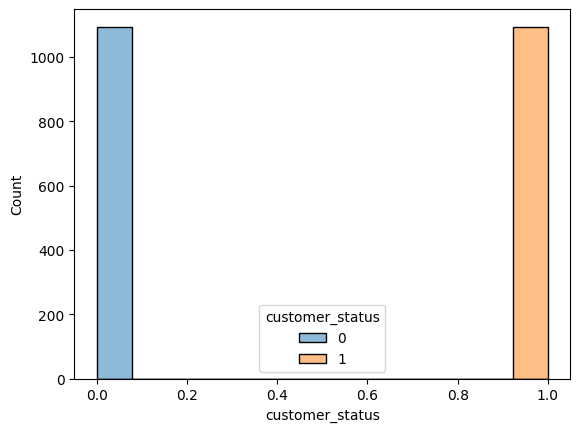

In [103]:
sns.histplot(data = train_set_rus, x = "customer_status", hue = "customer_status")

## SMOTE

In [89]:
def sm_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    # Create copy of set data
    set_data = set_data.copy()

    # Create sampling object
    sm = SMOTE(random_state=112)

    # Balancing set data
    x_sm, y_sm = sm.fit_resample(set_data.drop(
        "customer_status", axis=1), set_data.customer_status)

    # Concatenate balanced data
    set_data_sm = pd.concat([x_sm, y_sm], axis=1)

    # Return balanced data
    return set_data_sm

In [90]:
train_set_sm = sm_fit_resample(train_set)

<Axes: xlabel='customer_status', ylabel='Count'>

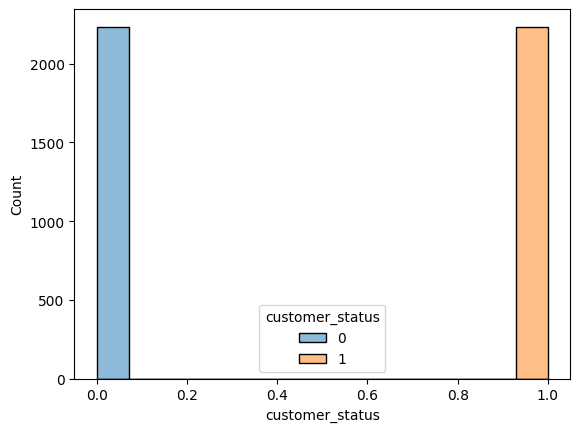

In [102]:
sns.histplot(data = train_set_sm, x = "customer_status", hue = "customer_status")

# Label Enconding

## Fit LE to Label

In [91]:
def le_fit(data_tobe_fitted: dict, le_path: str) -> LabelEncoder:
    # Create le object
    le_encoder = LabelEncoder()

    # Fit le
    le_encoder.fit(data_tobe_fitted)

    # Save le object
    util.pickle_dump(le_encoder, le_path)

    # Return trained le
    return le_encoder

In [92]:
le_encoder = le_fit(config_data["label_categories"], config_data["le_encoder_path"])

In [93]:
def le_transform(label_data: pd.Series, config_data: dict) -> pd.Series:
    # Create copy of label_data
    label_data = label_data.copy()

    # Load le encoder
    le_encoder = util.pickle_load(config_data["le_encoder_path"])

    # If customer_statuses both label data and trained le matched
    if len(set(label_data.unique()) - set(le_encoder.classes_) | set(le_encoder.classes_) - set(label_data.unique())) == 0:
        # Transform label data
        label_data = le_encoder.transform(label_data)
    else:
        raise RuntimeError("Check category in label data and label encoder.")

    # Return transformed label data
    return label_data


## LE RUS Set

In [94]:
train_set_rus.customer_status = le_transform(train_set_rus.customer_status, config_data)

## LE SMOTE Set

In [95]:
train_set_sm.customer_status = le_transform(train_set_sm.customer_status, config_data)

## LE Valid Set

In [96]:
valid_set.customer_status = le_transform(valid_set.customer_status, config_data)

## LE Test Set

In [97]:
test_set.customer_status = le_transform(test_set.customer_status, config_data)

# Dump Dataset

In [98]:
x_train = {
    "Undersampling": train_set_rus.drop(columns="customer_status"),
    "SMOTE": train_set_sm.drop(columns="customer_status")
}

y_train = {
    "Undersampling": train_set_rus.customer_status,
    "SMOTE": train_set_sm.customer_status
}


In [99]:
# check dataset length
print(len(x_train["SMOTE"]))
print(len(x_train["Undersampling"]))
print(len(valid_set))
print(len(test_set))

4470
2188
2462
2462


In [100]:
# util.pickle_dump(x_train, "data/processed/x_train_feng.pkl")
# util.pickle_dump(y_train, "data/processed/y_train_feng.pkl")

# util.pickle_dump(valid_set.drop(columns="customer_status"), "data/processed/x_valid_feng.pkl")
# util.pickle_dump(valid_set.customer_status, "data/processed/y_valid_feng.pkl")

# util.pickle_dump(test_set.drop(columns="customer_status"), "data/processed/x_test_feng.pkl")
# util.pickle_dump(test_set.customer_status, "data/processed/y_test_feng.pkl")